# Preprocessing and Training: UHC Insurance Dataset



In the prior notebook we were able to clean our data, combine our insurance dataset with CMS datasets alongside creating new features. In addition exploratory analysis was performed in the prior notebook.

In this notebook we will pre-process the data and create some basic models. As always, we will import the libraries we intend to work with.

In [58]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
import pyarrow as pa

## Import data

Let us import the dataframes we created in the prior notebook. Remember, this was a dictionary of dataframes that were downloaded separately.

In [59]:
path = 'data'
obj = os.scandir(path)
l = [entry for entry in obj]
df_dict = {}

for entry in l:
    p = entry.name[0:-8]
    df_dict[p] = pd.read_parquet('data/'+entry.name, engine='pyarrow')

The procedure I selected was for initial processing is the same as the prior notebook. Lets take a quick look and make sure we are pulling the right dataframe.

In [60]:
procedure = 'CPT58150'
df_dict[procedure].head().T

,0,1,2,3,4
ccn,290003,290039,290007,360144,100168
Procedure,CPT 58150,CPT 58150,CPT 58150,CPT 58150,CPT 58150
State Code,NV,NV,NV,OH,FL
Rural Versus Urban,U,U,U,U,U
PSI_03,0.13266,0.13266,0.13266,0.13266,0.13266
PSI_06,0.184709,0.184709,0.184709,0.184709,0.184709
PSI_08,0.114236,0.114236,0.114236,0.114236,0.114236
PSI_09,1.56662,1.56662,1.56662,1.56662,1.56662
PSI_10,0.650623,0.650623,0.650623,0.650623,0.650623
PSI_11,9.818181,9.818181,9.818181,9.818181,9.818181


We are going to create a simple pipeline using a linear regressor first, we must first drop the labeled columns and categorical columns. We are going to create a dummy regressor as a baseline to evaluate it.

In [61]:
X_train, X_test, y_train, y_test = train_test_split(df_dict[procedure].drop(columns='negotiated_rates_median'), 
                                                    df_dict[procedure]['negotiated_rates_median'], test_size=0.3, 
                                                    random_state=47)

We will also drop out categorical features for now.

In [62]:
names_list = ['ccn', 'Procedure', 'State Code','Rural Versus Urban']
names_train = X_train[names_list]
names_test = X_test[names_list]
X_train.drop(columns=names_list, inplace=True)
X_test.drop(columns=names_list, inplace=True)
X_train.shape, X_test.shape

((303, 34), (130, 34))

Let us check the dtypes for all of these columns.

In [63]:
X_train.dtypes

PSI_03                                                                         float64
PSI_06                                                                         float64
PSI_08                                                                         float64
PSI_09                                                                         float64
PSI_10                                                                         float64
PSI_11                                                                         float64
PSI_12                                                                         float64
PSI_13                                                                         float64
PSI_14                                                                         float64
PSI_15                                                                         float64
PSI_90                                                                         float64
HAI_1_SIR                                  

In [64]:
X_test.dtypes

PSI_03                                                                         float64
PSI_06                                                                         float64
PSI_08                                                                         float64
PSI_09                                                                         float64
PSI_10                                                                         float64
PSI_11                                                                         float64
PSI_12                                                                         float64
PSI_13                                                                         float64
PSI_14                                                                         float64
PSI_15                                                                         float64
PSI_90                                                                         float64
HAI_1_SIR                                  

Let us check the mean value of prices in this dataset and use this to create our dummy regressor.

In [65]:
train_mean = y_train.mean()
train_mean

1341.9522442244224

Let us see how a dummy regressor does by just predicting the mean for all values. This will help us establish a baseline for any model we create moving forward.

In [66]:
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[1341.95224422]])

Let us double check our dummy regressor. We can do this by applying the predict function on features of ones or our actual training set. Regardless of the input, we should get the mean as the output for each row.

In [67]:
y_tr_pred_ = train_mean * np.ones(len(y_train))
y_tr_pred_[:5]

array([1341.95224422, 1341.95224422, 1341.95224422, 1341.95224422,
       1341.95224422])

In [68]:
y_tr_pred = dumb_reg.predict(X_train)
y_tr_pred[:5]

array([1341.95224422, 1341.95224422, 1341.95224422, 1341.95224422,
       1341.95224422])

Looks like it is working as intended. Now let us get some useful evaluation metrics from our dummy regressor. $R^2$ , mean absolute error and mean squared error are metrics we can pull from the sklearn library. Let us apply this to our dummy regressor and use this as a baseline for the other regressors we build.

In [69]:
y_te_pred = train_mean * np.ones(len(y_test))
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0, -0.029884001947960925)

Exactly as expected, if you use the average value as your prediction, you get an $R^2$ of zero _on our training set_.

Generally, you can expect performance on a test set to be slightly worse than on the training set. As you are getting an $R^2$ of zero on the training set, hence the negative value.

In [70]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(256.40325708808507, 281.67419053059155)

Mean absolute error is arguably the most intuitive of all the metrics, this essentially tells you that, on average, you might expect to be off by around $281 if you guessed the price of this specific procedure based on the average of known procedure values.

In [71]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(109416.45312978195, 118129.22000760508)

So here, you get a slightly worse MSE on the test set than you did on the train set. This a metric that is useful in machine learning as a possible loss function.

Looks like they all match. Now we will fill all missing values with median terms. In prior notebooks we already filled missing values for all features depending on the feature. This is to make sure we have no missing values.

In [72]:
X_defaults_median = X_train.median()
X_tr = X_train.fillna(X_defaults_median)
X_te = X_test.fillna(X_defaults_median)

As you have features measured in many different units, with numbers that vary by orders of magnitude, start off by scaling them to put them all on a consistent scale. The [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) scales each feature to zero mean and unit variance.

In [73]:
scaler = StandardScaler()
scaler.fit(X_tr)
X_tr_scaled = scaler.transform(X_tr)
X_te_scaled = scaler.transform(X_te)

Now lets train the data on our new scaled features.

In [74]:
lm = LinearRegression().fit(X_tr_scaled, y_train)

Lets make predictions to evaluate our model.

In [75]:
y_tr_pred = lm.predict(X_tr_scaled)
y_te_pred = lm.predict(X_te_scaled)

Now lets apply the previous metrics and compare those values to our dummy regressor.

In [76]:
median_r2 = r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)
median_r2

(0.18495714887451464, 0.010988883616369516)

Remember we had 0 of our variance explained by our dummy regressor. This makes a sense because it always outputs the same value. However, here we have 18.5% and 1% of our variance explained by our linear regressor. Better than our dummy regressor, but not great.

In [77]:
median_mae = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
median_mae

(229.83363661073503, 261.7289035344566)

With the dummy regressor we were expected to be off by $281 if you guessed the price of this specific procedure based on the average of known procedure values. Here we are expected to be off by $262. This is better than our dummy regressor. Let us see we can do better.

In [78]:
median_mse = mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)
median_mse

(89179.09791893551, 113441.03951150838)

Since our linear pipeline did not work great, given the $R^2$ lets try another method. Let us trying using selectKbest features before applying a linear regression. `SelectKBest` which, as you might guess, selects the k best features.  `f_regression` is just the [score function](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression) you're using because you're performing regression.

In [79]:
pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(score_func=f_regression),
    LinearRegression()
)

In [80]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x000002CFDECE7E50>)),
                ('linearregression', LinearRegression())])

In [81]:
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

In [82]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.1051167802757218, -0.008770836676242233)

In [83]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(243.20936728067014, 273.10518361338524)

Looks like this made things worse. The default k selected is 10, lets increase the number to 15.

In [84]:
pipe15 = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(score_func=f_regression, k=15),
    LinearRegression()
)

In [85]:
pipe15.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=15,
                             score_func=<function f_regression at 0x000002CFDECE7E50>)),
                ('linearregression', LinearRegression())])

In [86]:
y_tr_pred = pipe15.predict(X_train)
y_te_pred = pipe15.predict(X_test)

In [87]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.12108551901135411, -0.016025448787830188)

In [88]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(239.4213844063878, 274.05286020292806)

This model did slightly better than when k was set to 10; however, it seems to be overfitting to the training data. Let us apply validation as well.

In [89]:
cv_results = cross_validate(pipe15, X_train, y_train, cv=5)

In [90]:
cv_scores = cv_results['test_score']
cv_scores

array([-0.02201717,  0.09620838,  0.01600219, -0.03819649, -0.12262421])

In [91]:
np.mean(cv_scores), np.std(cv_scores)

(-0.014125459154356946, 0.07140715082047258)

In [92]:
np.round((np.mean(cv_scores) - 2 * np.std(cv_scores), np.mean(cv_scores) + 2 * np.std(cv_scores)), 2)

array([-0.16,  0.13])

This produces a poor model as well. Let us try to determine the best number of features to select using grid search.

In [93]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'linearregression', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__keep_empty_features', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__positive'])

In [94]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [95]:
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [96]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000002CFDECE7E50>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

In [97]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [98]:
lr_grid_cv.best_params_

{'selectkbest__k': 6}

Looks like the best number to set k to is 6, let us look at each model within the grid search and how it performed. 

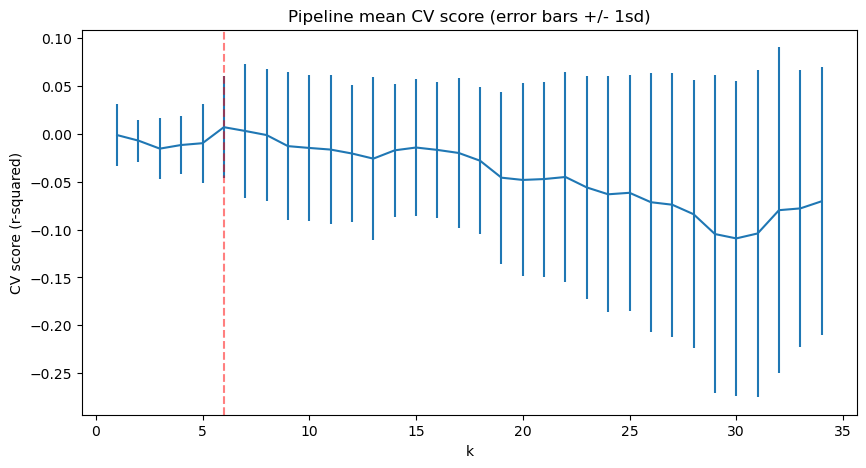

In [99]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [100]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

In [101]:
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

hospital_ratio                           48.053030
HAI_1_SIR                                42.857459
hospitals_per_100kcapita                 40.740605
Number of Interns and Residents (FTE)    21.697800
PSI_08                                   -7.326492
discharges_per_100kcapita               -41.759411
dtype: float64

Of the selected features, looks like hospital ratio and hospitals per 100k capita were selected. This should not be surprising given these showed up in exploratory analysis. Numerous hospital demand metrics are displayed here, which is in line with what we saw in the prior notebook.

Regardless, the $R^2$ is a low for all of these values, let us try a different method for determining the price of this procedure.

In [102]:
RF_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestRegressor(random_state=47)
)

In [103]:
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

In [104]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([-0.28200218, -0.08276224, -0.05012757, -0.0870017 , -0.46973033])

In [105]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(-0.1943248047611997, 0.1601829101073477)

In [106]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
        'simpleimputer__strategy': ['mean', 'median']
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None],
 'simpleimputer__strategy': ['mean', 'median']}

In [107]:
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [108]:
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [StandardScaler(), None]})

In [109]:
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 379,
 'simpleimputer__strategy': 'mean',
 'standardscaler': StandardScaler()}

In [110]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([-0.27167312, -0.08100311, -0.03198504, -0.1002379 , -0.45323006])

In [111]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(-0.1876258487993748, 0.15545974604156568)

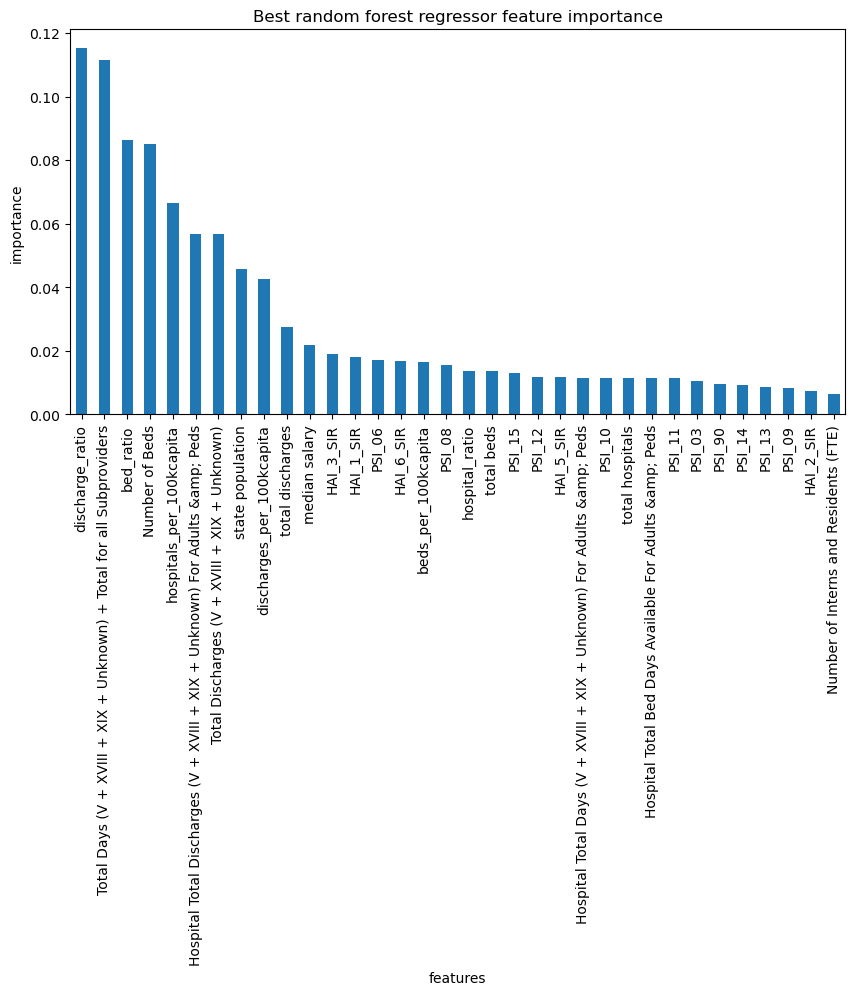

In [112]:
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importance');

In [113]:
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [114]:
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
lr_mae_mean, lr_mae_std

(253.36515516248005, 31.404341486349857)

In [115]:
mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))

269.0729547810762

In [116]:
rf_neg_mae = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [117]:
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

(271.65487742693614, 18.741803516022756)

In [118]:
mean_absolute_error(y_test, rf_grid_cv.best_estimator_.predict(X_test))

275.9846394357625

In [119]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(pipe, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

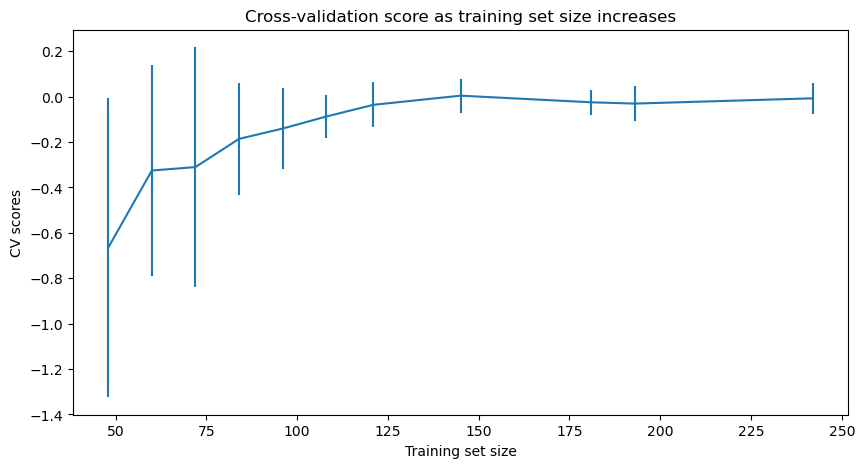

In [120]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

In [121]:
best_model = rf_grid_cv.best_estimator_
best_model.version = 1
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [122]:
data= df_dict[procedure]
one_hot = pd.get_dummies(data, columns=['Rural Versus Urban'], drop_first= True)

X_train, X_test, y_train, y_test = train_test_split(one_hot.drop(columns='negotiated_rates_median'), 
                                                    one_hot['negotiated_rates_median'], test_size=0.2, 
                                                    random_state=47)

names_list = ['ccn', 'Procedure', 'State Code']
names_train = X_train[names_list]
names_test = X_test[names_list]
X_train.drop(columns=names_list, inplace=True)
X_test.drop(columns=names_list, inplace=True)
X_train.shape, X_test.shape

((346, 35), (87, 35))

In [123]:
RF_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestRegressor(random_state=47)
)

In [124]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
        'simpleimputer__strategy': ['mean', 'median']
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None],
 'simpleimputer__strategy': ['mean', 'median']}

In [125]:
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [126]:
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [StandardScaler(), None]})

In [127]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([-0.19278656, -0.13751316, -0.04285065, -0.03233385, -0.3390437 ])

In [ ]:
rf_grid_cv.best_params_

In [128]:
mean_absolute_error(y_test, rf_grid_cv.best_estimator_.predict(X_test))

288.7772882442903

Looks like even including the data about if the hospital is rural or urban did not help the random forest tree.

